In [1]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch
from torchvision.models import resnet50, ResNet50_Weights, VGG16_Weights,vgg16,densenet169,DenseNet169_Weights,efficientnet_b6,EfficientNet_B6_Weights,resnet152,ResNet152_Weights,DenseNet121_Weights,densenet121
import torch.nn as nn
from torch.optim import NAdam, Adam, SGD

In [2]:
import sys
!{sys.executable} -m pip install gdown h5py

In [3]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
# gdown.download(url, output, quiet=False, fuzzy=True)


### Load the data

In [176]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [5]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


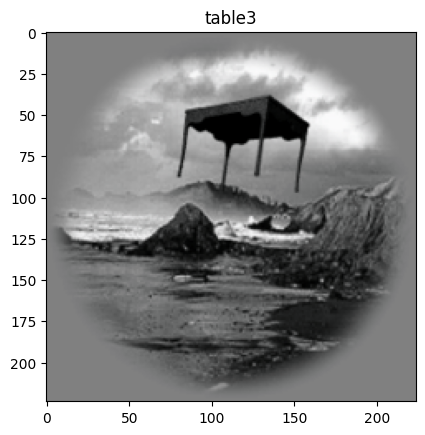

In [6]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

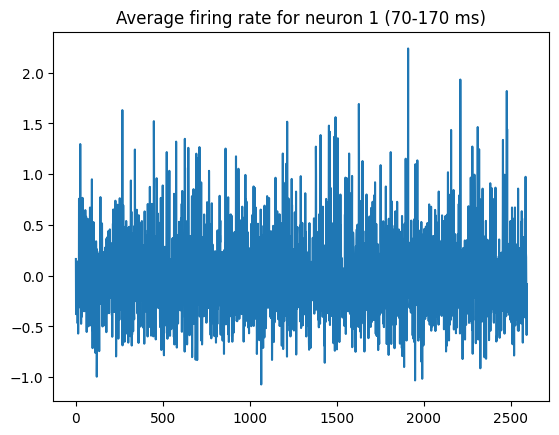

In [7]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

# NEW TRAINING

In [130]:

def train_model(model,scheduler, train_loader, validation_dataloader, criterion, optimizer, num_epochs=10, device='cuda', classification=False):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        val_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            if classification:
                loss = criterion(outputs, labels)
            else:
                loss = criterion(outputs, labels)**0.5

            loss.backward()
            optimizer.step()
            if not scheduler is None:
                scheduler.step()

            running_loss += loss.item() * inputs.size(0)

        for inputs, labels in validation_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss = val_loss / len(validation_dataloader.dataset)

        print(f'Epoch [{epoch+1}/{num_epochs}], train loss: {epoch_loss:.4f}, val loss: {val_loss:.4f}')



In [154]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [10]:
# Define your custom layer
class CustomLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomLayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        # Add any other layers or modifications as needed
        nn.init.kaiming_normal_(self.fc.weight)
        nn.init.zeros_(self.fc.bias) 

    def forward(self, x):
        x = self.fc(x)
        # Add any other operations in the forward pass
        return x

In [11]:
train_dataset = CustomTensorDataset((torch.Tensor(stimulus_train), torch.Tensor(spikes_train)), transform=ResNet50_Weights.IMAGENET1K_V2.transforms())


validation_dataset = CustomTensorDataset((torch.Tensor(stimulus_val), torch.Tensor(spikes_val)), transform=ResNet50_Weights.IMAGENET1K_V2.transforms())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=24, shuffle=True)

In [13]:
resnet = resnet50(pretrained=True)

in_features = resnet.fc.in_features

custom_layer = CustomLayer(in_features, spikes_train.shape[1])  #

resnet.fc = custom_layer

criterion = nn.MSELoss()
num_epochs= 20
batch_size=32

optimizer = NAdam(resnet.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=1e-3, total_steps=num_epochs*stimulus_train.shape[0]//batch_size, 
                                                            pct_start=0.1, anneal_strategy="linear", 
                                                            cycle_momentum=False, div_factor=1e2, final_div_factor=.1)

train_model(resnet, scheduler, train_loader, validation_loader,criterion, optimizer, num_epochs=num_epochs)

Epoch [1/20], train loss: 0.4067, val loss: 0.1073
Epoch [2/20], train loss: 0.3138, val loss: 0.1031
Epoch [3/20], train loss: 0.2828, val loss: 0.0798
Epoch [4/20], train loss: 0.2575, val loss: 0.0749
Epoch [5/20], train loss: 0.2406, val loss: 0.0733
Epoch [6/20], train loss: 0.2307, val loss: 0.0676
Epoch [7/20], train loss: 0.2216, val loss: 0.0753
Epoch [8/20], train loss: 0.2136, val loss: 0.0674
Epoch [9/20], train loss: 0.1997, val loss: 0.0698
Epoch [10/20], train loss: 0.1874, val loss: 0.0667
Epoch [11/20], train loss: 0.1903, val loss: 0.0642
Epoch [12/20], train loss: 0.1803, val loss: 0.0652
Epoch [13/20], train loss: 0.1638, val loss: 0.0658
Epoch [14/20], train loss: 0.1567, val loss: 0.0655
Epoch [15/20], train loss: 0.1473, val loss: 0.0639
Epoch [16/20], train loss: 0.1336, val loss: 0.0651
Epoch [17/20], train loss: 0.1239, val loss: 0.0644
Epoch [18/20], train loss: 0.1128, val loss: 0.0654
Epoch [19/20], train loss: 0.1024, val loss: 0.0628
Epoch [20/20], train 

In [14]:

resnet = resnet50(pretrained=True)


in_features = resnet.fc.in_features

custom_layer = CustomLayer(in_features, spikes_train.shape[1])  #

resnet.fc = custom_layer
for param in resnet.parameters():
    param.requires_grad = False

# Unfreeze the fully connected layer for fine-tuning
for param in resnet.fc.parameters():
    param.requires_grad = True
criterion = nn.MSELoss()
num_epochs= 20
batch_size=32

optimizer = NAdam(resnet.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=1e-3, total_steps=num_epochs*stimulus_train.shape[0]//batch_size, 
                                                            pct_start=0.1, anneal_strategy="linear", 
                                                            cycle_momentum=False, div_factor=1e2, final_div_factor=.1)

train_model(resnet, scheduler, train_loader, validation_loader,criterion, optimizer, num_epochs=num_epochs)

Epoch [1/20], train loss: 0.5672, val loss: 0.2434
Epoch [2/20], train loss: 0.5021, val loss: 0.2983
Epoch [3/20], train loss: 0.4880, val loss: 0.2170
Epoch [4/20], train loss: 0.4383, val loss: 0.1739
Epoch [5/20], train loss: 0.4105, val loss: 0.1735
Epoch [6/20], train loss: 0.3907, val loss: 0.1606
Epoch [7/20], train loss: 0.3731, val loss: 0.1504
Epoch [8/20], train loss: 0.3585, val loss: 0.1387
Epoch [9/20], train loss: 0.3479, val loss: 0.1341
Epoch [10/20], train loss: 0.3404, val loss: 0.1235
Epoch [11/20], train loss: 0.3307, val loss: 0.1217
Epoch [12/20], train loss: 0.3246, val loss: 0.1213
Epoch [13/20], train loss: 0.3200, val loss: 0.1189
Epoch [14/20], train loss: 0.3168, val loss: 0.1178
Epoch [15/20], train loss: 0.3112, val loss: 0.1161
Epoch [16/20], train loss: 0.3074, val loss: 0.1154
Epoch [17/20], train loss: 0.3048, val loss: 0.1143
Epoch [18/20], train loss: 0.3028, val loss: 0.1132
Epoch [19/20], train loss: 0.3001, val loss: 0.1114
Epoch [20/20], train 

In [11]:
train_dataset = CustomTensorDataset((torch.Tensor(stimulus_train), torch.Tensor(spikes_train)), transform=ResNet152_Weights.IMAGENET1K_V2.transforms())


validation_dataset = CustomTensorDataset((torch.Tensor(stimulus_val), torch.Tensor(spikes_val)), transform=ResNet152_Weights.IMAGENET1K_V2.transforms())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=24, shuffle=True)

In [12]:
resnet = resnet152(pretrained=True)


in_features = resnet.fc.in_features

custom_layer = CustomLayer(in_features, spikes_train.shape[1])  #

resnet.fc = custom_layer
for param in resnet.parameters():
    param.requires_grad = False

# Unfreeze the fully connected layer for fine-tuning
for param in resnet.fc.parameters():
    param.requires_grad = True
criterion = nn.MSELoss()
num_epochs= 20
batch_size=32

optimizer = NAdam(resnet.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=1e-3, total_steps=num_epochs*stimulus_train.shape[0]//batch_size, 
                                                            pct_start=0.1, anneal_strategy="linear", 
                                                            cycle_momentum=False, div_factor=1e2, final_div_factor=.1)

train_model(resnet, scheduler, train_loader, validation_loader,criterion, optimizer, num_epochs=num_epochs)

/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /home/reategui/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:00<00:00, 337MB/s] 


Epoch [1/20], train loss: 0.5793, val loss: 0.2441
Epoch [2/20], train loss: 0.5041, val loss: 0.2956
Epoch [3/20], train loss: 0.4884, val loss: 0.2222
Epoch [4/20], train loss: 0.4385, val loss: 0.1949
Epoch [5/20], train loss: 0.4087, val loss: 0.1680
Epoch [6/20], train loss: 0.3890, val loss: 0.1591
Epoch [7/20], train loss: 0.3730, val loss: 0.1480
Epoch [8/20], train loss: 0.3603, val loss: 0.1500
Epoch [9/20], train loss: 0.3536, val loss: 0.1391
Epoch [10/20], train loss: 0.3425, val loss: 0.1369
Epoch [11/20], train loss: 0.3326, val loss: 0.1319
Epoch [12/20], train loss: 0.3281, val loss: 0.1270
Epoch [13/20], train loss: 0.3217, val loss: 0.1265
Epoch [14/20], train loss: 0.3186, val loss: 0.1283
Epoch [15/20], train loss: 0.3146, val loss: 0.1207
Epoch [16/20], train loss: 0.3093, val loss: 0.1206
Epoch [17/20], train loss: 0.3060, val loss: 0.1177
Epoch [18/20], train loss: 0.3042, val loss: 0.1161
Epoch [19/20], train loss: 0.3019, val loss: 0.1156
Epoch [20/20], train 

In [15]:
train_dataset = CustomTensorDataset((torch.Tensor(stimulus_train), torch.Tensor(spikes_train)), transform=VGG16_Weights.IMAGENET1K_V1.transforms())


validation_dataset = CustomTensorDataset((torch.Tensor(stimulus_val), torch.Tensor(spikes_val)), transform=VGG16_Weights.IMAGENET1K_V1.transforms())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=24, shuffle=True)

In [16]:
vgg = vgg16(pretrained=True)

in_features = vgg.classifier[6].in_features

custom_layer = CustomLayer(in_features, spikes_train.shape[1])  #

vgg.classifier[6] = custom_layer

criterion = nn.MSELoss()
num_epochs= 20
batch_size=32

optimizer = NAdam(vgg.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=1e-3, total_steps=num_epochs*stimulus_train.shape[0]//batch_size, 
                                                            pct_start=0.1, anneal_strategy="linear", 
                                                            cycle_momentum=False, div_factor=1e2, final_div_factor=.1)

train_model(vgg, scheduler, train_loader, validation_loader,criterion, optimizer, num_epochs=num_epochs)

/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], train loss: 0.4469, val loss: 0.1382
Epoch [2/20], train loss: 0.4642, val loss: 0.1414
Epoch [3/20], train loss: 0.3721, val loss: 0.1409
Epoch [4/20], train loss: 0.3685, val loss: 0.1410
Epoch [5/20], train loss: 0.3683, val loss: 0.1409
Epoch [6/20], train loss: 0.3689, val loss: 0.1410
Epoch [7/20], train loss: 0.3684, val loss: 0.1410
Epoch [8/20], train loss: 0.3683, val loss: 0.1409
Epoch [9/20], train loss: 0.3683, val loss: 0.1409
Epoch [10/20], train loss: 0.3683, val loss: 0.1410
Epoch [11/20], train loss: 0.3682, val loss: 0.1408
Epoch [12/20], train loss: 0.3684, val loss: 0.1410
Epoch [13/20], train loss: 0.3682, val loss: 0.1410
Epoch [14/20], train loss: 0.3682, val loss: 0.1410
Epoch [15/20], train loss: 0.3683, val loss: 0.1410
Epoch [16/20], train loss: 0.3681, val loss: 0.1409
Epoch [17/20], train loss: 0.3683, val loss: 0.1409
Epoch [18/20], train loss: 0.3683, val loss: 0.1409
Epoch [19/20], train loss: 0.3682, val loss: 0.1409
Epoch [20/20], train 

In [18]:
vgg = vgg16(pretrained=True)

in_features = vgg.classifier[0].in_features

custom_layer = CustomLayer(in_features, spikes_train.shape[1])  #

vgg.classifier = custom_layer

criterion = nn.MSELoss()
num_epochs= 20
batch_size=32

optimizer = torch.optim.SGD(vgg.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=1e-3, total_steps=num_epochs*stimulus_train.shape[0]//batch_size, 
                                                            pct_start=0.1, anneal_strategy="linear", 
                                                            cycle_momentum=False, div_factor=1e2, final_div_factor=.1)

train_model(vgg, scheduler, train_loader, validation_loader,criterion, optimizer, num_epochs=num_epochs)

/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], train loss: 0.8099, val loss: 0.1537
Epoch [2/20], train loss: 0.3759, val loss: 0.1433
Epoch [3/20], train loss: 0.3700, val loss: 0.1416
Epoch [4/20], train loss: 0.3686, val loss: 0.1408
Epoch [5/20], train loss: 0.3681, val loss: 0.1405
Epoch [6/20], train loss: 0.3678, val loss: 0.1404
Epoch [7/20], train loss: 0.3679, val loss: 0.1405
Epoch [8/20], train loss: 0.3679, val loss: 0.1406
Epoch [9/20], train loss: 0.3680, val loss: 0.1407
Epoch [10/20], train loss: 0.3680, val loss: 0.1408
Epoch [11/20], train loss: 0.3681, val loss: 0.1408
Epoch [12/20], train loss: 0.3681, val loss: 0.1409
Epoch [13/20], train loss: 0.3682, val loss: 0.1409
Epoch [14/20], train loss: 0.3682, val loss: 0.1409
Epoch [15/20], train loss: 0.3682, val loss: 0.1409
Epoch [16/20], train loss: 0.3682, val loss: 0.1409
Epoch [17/20], train loss: 0.3682, val loss: 0.1409
Epoch [18/20], train loss: 0.3682, val loss: 0.1409
Epoch [19/20], train loss: 0.3682, val loss: 0.1409
Epoch [20/20], train 

In [15]:
train_dataset = CustomTensorDataset((torch.Tensor(stimulus_train), torch.Tensor(spikes_train)), transform=DenseNet121_Weights.IMAGENET1K_V1.transforms())


validation_dataset = CustomTensorDataset((torch.Tensor(stimulus_val), torch.Tensor(spikes_val)), transform=DenseNet121_Weights.IMAGENET1K_V1.transforms())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=24, shuffle=True)

In [16]:
densenet = densenet121(pretrained=True)

in_features = densenet.classifier.in_features

custom_layer = CustomLayer(in_features, spikes_train.shape[1])  #

densenet.classifier = custom_layer

criterion = nn.MSELoss()
num_epochs= 20
batch_size=32

optimizer = NAdam(densenet.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=1e-3, total_steps=num_epochs*stimulus_train.shape[0]//batch_size, 
                                                             pct_start=0.1, anneal_strategy="linear")

train_model(densenet, scheduler, train_loader, validation_loader,criterion, optimizer, num_epochs=num_epochs)

/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/reategui/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 237MB/s]


Epoch [1/20], train loss: 0.5344, val loss: 0.1119
Epoch [2/20], train loss: 0.3271, val loss: 0.1123
Epoch [3/20], train loss: 0.3057, val loss: 0.0853
Epoch [4/20], train loss: 0.2765, val loss: 0.0804
Epoch [5/20], train loss: 0.2600, val loss: 0.0804
Epoch [6/20], train loss: 0.2441, val loss: 0.0713
Epoch [7/20], train loss: 0.2318, val loss: 0.0708
Epoch [8/20], train loss: 0.2177, val loss: 0.0676
Epoch [9/20], train loss: 0.2071, val loss: 0.0687
Epoch [10/20], train loss: 0.1949, val loss: 0.0674
Epoch [11/20], train loss: 0.1840, val loss: 0.0671
Epoch [12/20], train loss: 0.1743, val loss: 0.0700
Epoch [13/20], train loss: 0.1629, val loss: 0.0680
Epoch [14/20], train loss: 0.1521, val loss: 0.0693
Epoch [15/20], train loss: 0.1418, val loss: 0.0690
Epoch [16/20], train loss: 0.1302, val loss: 0.0680
Epoch [17/20], train loss: 0.1196, val loss: 0.0671
Epoch [18/20], train loss: 0.1093, val loss: 0.0671
Epoch [19/20], train loss: 0.1002, val loss: 0.0678
Epoch [20/20], train 

In [60]:
train_dataset = CustomTensorDataset((torch.Tensor(stimulus_train), torch.Tensor(spikes_train)), transform=DenseNet169_Weights.IMAGENET1K_V1.transforms())


validation_dataset = CustomTensorDataset((torch.Tensor(stimulus_val), torch.Tensor(spikes_val)), transform=DenseNet169_Weights.IMAGENET1K_V1.transforms())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=24, shuffle=True)

In [61]:
densenet = densenet169(pretrained=True)

in_features = densenet.classifier.in_features

custom_layer = CustomLayer(in_features, spikes_train.shape[1])  #

densenet.classifier = custom_layer

criterion = nn.MSELoss()
num_epochs= 20
batch_size=32

optimizer = NAdam(densenet.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=1e-3, total_steps=num_epochs*stimulus_train.shape[0]//batch_size, 
                                                             pct_start=0.1, anneal_strategy="linear")

train_model(densenet, scheduler, train_loader, validation_loader,criterion, optimizer, num_epochs=num_epochs)

Epoch [1/20], train loss: 0.4438, val loss: 0.1085
Epoch [2/20], train loss: 0.3292, val loss: 0.1164
Epoch [3/20], train loss: 0.3087, val loss: 0.0947
Epoch [4/20], train loss: 0.2794, val loss: 0.0872
Epoch [5/20], train loss: 0.2591, val loss: 0.0742
Epoch [6/20], train loss: 0.2453, val loss: 0.0714
Epoch [7/20], train loss: 0.2289, val loss: 0.0695
Epoch [8/20], train loss: 0.2142, val loss: 0.0692
Epoch [9/20], train loss: 0.2007, val loss: 0.0719
Epoch [10/20], train loss: 0.1871, val loss: 0.0700
Epoch [11/20], train loss: 0.1743, val loss: 0.0692
Epoch [12/20], train loss: 0.1657, val loss: 0.0744
Epoch [13/20], train loss: 0.1506, val loss: 0.0676
Epoch [14/20], train loss: 0.1383, val loss: 0.0715
Epoch [15/20], train loss: 0.1278, val loss: 0.0669
Epoch [16/20], train loss: 0.1156, val loss: 0.0688
Epoch [17/20], train loss: 0.1041, val loss: 0.0681
Epoch [18/20], train loss: 0.0951, val loss: 0.0663
Epoch [19/20], train loss: 0.0846, val loss: 0.0673
Epoch [20/20], train 

In [11]:
train_dataset = CustomTensorDataset((torch.Tensor(stimulus_train), torch.Tensor(spikes_train)), transform=EfficientNet_B6_Weights.IMAGENET1K_V1.transforms())


validation_dataset = CustomTensorDataset((torch.Tensor(stimulus_val), torch.Tensor(spikes_val)), transform=EfficientNet_B6_Weights.IMAGENET1K_V1.transforms())

train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=True)

In [12]:
efficientnet = efficientnet_b6(pretrained=True)

in_features = efficientnet.classifier[1].in_features

custom_layer = CustomLayer(in_features, spikes_train.shape[1])  #

efficientnet.classifier[1] = custom_layer

criterion = nn.MSELoss()
num_epochs= 20
batch_size=24

optimizer = torch.optim.SGD(efficientnet.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=1e-3, total_steps=num_epochs*stimulus_train.shape[0]//batch_size, 
                                                             pct_start=0.1, anneal_strategy="linear")

train_model(efficientnet, scheduler, train_loader, validation_loader,criterion, optimizer, num_epochs=num_epochs)

/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B6_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B6_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], train loss: 0.4596, val loss: 0.1981
Epoch [2/20], train loss: 0.4411, val loss: 0.1843
Epoch [3/20], train loss: 0.4253, val loss: 0.1749
Epoch [4/20], train loss: 0.4149, val loss: 0.1683
Epoch [5/20], train loss: 0.4058, val loss: 0.1621
Epoch [6/20], train loss: 0.3989, val loss: 0.1580
Epoch [7/20], train loss: 0.3929, val loss: 0.1543
Epoch [8/20], train loss: 0.3878, val loss: 0.1521
Epoch [9/20], train loss: 0.3837, val loss: 0.1506
Epoch [10/20], train loss: 0.3812, val loss: 0.1480
Epoch [11/20], train loss: 0.3787, val loss: 0.1467
Epoch [12/20], train loss: 0.3767, val loss: 0.1459


# Strong inductive bias

In [25]:
import torch
from torchvision.models import densenet169

pretrained = False
densenet = densenet169(pretrained=pretrained).cpu()

densenet.eval()

/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Extraction of densenet layers

In [26]:
densenet_layers = {
    'conv0': densenet.features.conv0,
    'denseblock1': densenet.features.denseblock1,
    'denseblock2': densenet.features.denseblock2,
    'denseblock3': densenet.features.denseblock3,
    'denseblock4': densenet.features.denseblock4,
    'transition1': densenet.features.transition1,
    'transition2': densenet.features.transition2,
    'transition3': densenet.features.transition3,
    'norm5': densenet.features.norm5,
}

In [8]:
densenet_shapes = {
    'conv0': 802816,
    'denseblock1': 802816,
    'denseblock2': 401408,
    'denseblock3': 250880,
    'denseblock4': 81536,
    'transition1': 100352,
    'transition2': 50176,
    'transition3': 31360,
    'norm5': 81536,
}

In [28]:
for stimulus, suffix, batch_size in zip ((stimulus_train, stimulus_val), ("train", "val"), (162,32)):
    if pretrained:
        folder = "densenet169/pretrained"
    else:
        folder = "densenet169/randomly_initialized"
    activation_files = {name: np.memmap(f"{folder}/{name}_activations_{suffix}.npy" , dtype=np.float32, mode='w+', shape=(len(stimulus),densenet_shapes[name]))
                        for name in densenet_layers.keys()}

    def hook(name, idx):
        def hook(module, input, output):
            output = output.detach().cpu().reshape(batch_size, -1).numpy()
            activation_files[name][idx*batch_size:(idx+1)*batch_size,:] = output  
            activation_files[name].flush()
        return hook

    for key,layer in densenet_layers.items():

        for idx in tqdm(range(len(stimulus)//batch_size)):
            hook_handle = layer.register_forward_hook(hook(key,idx))
            batch = stimulus[idx*batch_size:(idx+1)*batch_size]
            _ = densenet(torch.tensor(batch))
            hook_handle.remove()

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:04<00:00,  1.93it/s]


In [29]:
device = "cuda"

Computing the pca using torch.low_rank implementation on cuda can lead to strong speed ups

In [74]:
pretrained = True

In [77]:
num_components = 1000  
if pretrained:
    folder = "densenet169/pretrained"
else:
    folder = "densenet169/randomly_initialized"

for key,item in tqdm(densenet_shapes.items()):
    array = torch.tensor(np.memmap(f"{folder}/{key}_activations_train.npy" , mode='r',shape=(len(stimulus_train),item), dtype=np.float32), dtype=torch.float32).to(device)

    U, S, V = torch.pca_lowrank(array, q=num_components)
    array = torch.matmul(array, V).cpu().numpy()
    np.save(f"{folder}/{key}_{num_components}PCs_train.npy", array)

    array = torch.tensor(np.memmap(f"{folder}/{key}_activations_val.npy" , mode='r',shape=(len(stimulus_val),item), dtype=np.float32), dtype=torch.float32).to(device)
    array = torch.matmul(array, V).cpu().numpy()
    np.save(f"{folder}/{key}_{num_components}PCs_val.npy", array)

100%|██████████| 9/9 [00:21<00:00,  2.41s/it]


In [31]:
num_components = 1000

Loading saved pca activations

In [203]:
import numpy as np
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,MultiTaskLassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler

Scoring function

In [10]:
def analyze(folder, model_name):
    scores = {}

    for layer in list(densenet_shapes.keys())+["all"]:
        scores[layer] = {}
        if layer == "all":
            activations_train = np.concatenate([np.load(f"{folder}/{key}_{num_components}PCs_train.npy") for key in densenet_shapes.keys()], axis=1)
            activations_val = np.concatenate([np.load(f"{folder}/{key}_{num_components}PCs_val.npy") for key in densenet_shapes.keys()], axis=1)
        else:
            activations_train = np.load(f"{folder}/{layer}_{num_components}PCs_train.npy")
            activations_val = np.load(f"{folder}/{layer}_{num_components}PCs_val.npy")
        if model_name == "Linear":
            model = LinearRegression()
            model.fit(activations_train, spikes_train)
        elif model_name == "Ridge":
            alphas = np.logspace(-12, 12, 26)
            model = RidgeCV(alphas=alphas, store_cv_values=True)
            model.fit(activations_train, spikes_train)
        else: 
            NotImplementedError
        print(f"Layer {layer}")

        for activations, set_name, spikes in zip((activations_train,activations_val), ("train", "validation"), (spikes_train, spikes_val)):
            y_pred = model.predict(activations)
            mse = mean_squared_error(spikes, y_pred)
            rmse = np.sqrt(mse)

            r2 = r2_score(spikes, y_pred)
            explained_variance = explained_variance_score(spikes, y_pred)
            print(f"Set name : {set_name}")
            print(f"RMSE: {rmse}")
            print("R2:", r2)
            print("Explained Variance:", explained_variance)
            if set_name == "validation":
                scores[layer]["r2"] = r2
                scores[layer]["explained_variance"] = explained_variance

        print("\n\n")
    return scores

In [22]:
scores = analyze("densenet169/pretrained", "Linear")

Layer conv0
Set name : train
RMSE: 0.26890695095062256
R2: 0.4617477450281142
Explained Variance: 0.46174769529274534
Set name : validation
RMSE: 0.3859172761440277
R2: -0.08465034955311676
Explained Variance: -0.08027662691615876



Layer denseblock1
Set name : train
RMSE: 0.2313060611486435
R2: 0.585388647671731
Explained Variance: 0.5853886625596455
Set name : validation
RMSE: 0.3249262571334839
R2: 0.20883118219222124
Explained Variance: 0.21195231058767863



Layer denseblock2
Set name : train
RMSE: 0.21164238452911377
R2: 0.6393045523482115
Explained Variance: 0.6393045488567579
Set name : validation
RMSE: 0.3000248372554779
R2: 0.2987402641821276
Explained Variance: 0.30209525035960333



Layer denseblock3
Set name : train
RMSE: 0.19161456823349
R2: 0.6884945346038625
Explained Variance: 0.688494530816873
Set name : validation
RMSE: 0.27302488684654236
R2: 0.38751248168457136
Explained Variance: 0.39040951643671307



Layer denseblock4
Set name : train
RMSE: 0.18907786905765533


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-0.08027662691615876, 0.21195231058767863, 0.30209525035960333, 0.39040951643671307, 0.3897214769607499, 0.2524244285055569, 0.3409611274089132, 0.37046900143225986, 0.31728752454121906]
[-0.08465034955311676, 0.20883118219222124, 0.2987402641821276, 0.38751248168457136, 0.38704629755416986, 0.24871542076778042, 0.3376858265650503, 0.36795293979131843, 0.3145600252981896]


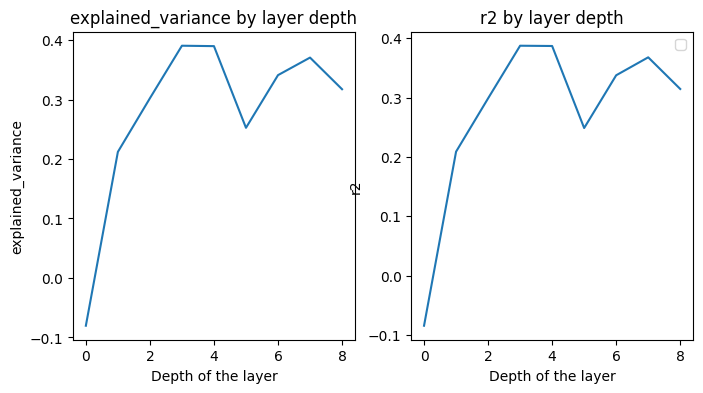

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
for ax, metric in zip(axs,("explained_variance", "r2")):
    values = [scores[key][metric] for key in densenet_shapes.keys()]
    print(values)
    ax.plot(range(len(values)), values)
    ax.set_xlabel("Depth of the layer")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by layer depth")
plt.legend()

In [55]:
scores = analyze("densenet169/randomly_initialized", "Linear")

Layer conv0
Set name : train
RMSE: 0.26865243911743164
R2: 0.4627954817386901
Explained Variance: 0.4627954612175624
Set name : validation
RMSE: 0.38360852003097534
R2: -0.07304874651383764
Explained Variance: -0.06862604724509376



Layer denseblock1
Set name : train
RMSE: 0.24164177477359772
R2: 0.5524908961393538
Explained Variance: 0.5524909176996776
Set name : validation
RMSE: 0.3430125117301941
R2: 0.11659031217499742
Explained Variance: 0.12135056832006999



Layer denseblock2
Set name : train
RMSE: 0.23614001274108887
R2: 0.5698672233841126
Explained Variance: 0.5698672543678965
Set name : validation
RMSE: 0.33948516845703125
R2: 0.13104351025786526
Explained Variance: 0.1359152974826949



Layer denseblock3
Set name : train
RMSE: 0.22899946570396423
R2: 0.5915132385373089
Explained Variance: 0.591513258360681
Set name : validation
RMSE: 0.3271777927875519
R2: 0.18391635396329414
Explained Variance: 0.18901154079607554



Layer denseblock4
Set name : train
RMSE: 0.2256847172975

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-0.06263752565497444, 0.12059093798909869, 0.13408808268251873, 0.18776171867336547, 0.20341124066284724, 0.1009994333698636, 0.15137553002153123, 0.18714955768414906, 0.19994834845974332]
[-0.06681207915539204, 0.11599090593542345, 0.12944877344041428, 0.1833769158068012, 0.19947566250801976, 0.0960443530517986, 0.14707408285017604, 0.1833060023536906, 0.19620836328157376]


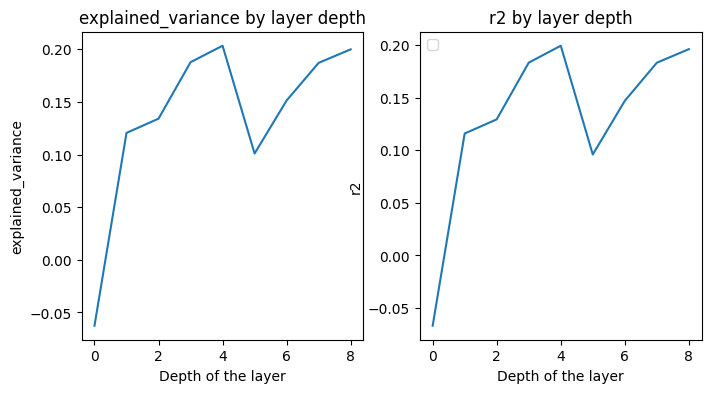

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
for ax, metric in zip(axs,("explained_variance", "r2")):
    values = [scores[key][metric] for key in densenet_shapes.keys()]
    print(values)
    ax.plot(range(len(values)), values)
    ax.set_xlabel("Depth of the layer")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by layer depth")
plt.legend()

In [56]:
np.memmap(f"{folder}/{key}_activations_train.npy" , mode='r',shape=(len(stimulus_train),item), dtype=np.float32)

memmap([[-5.9303045e-03, -1.2694963e-03, -1.3128640e-03, ...,
          1.5094582e+00,  5.1789784e-01, -3.4899071e-01],
        [-6.8067228e-03, -1.2840074e-03, -6.1298651e-04, ...,
          1.7783561e+00,  9.7766119e-01,  3.3551419e-01],
        [-6.3204705e-03, -9.7617932e-04,  8.6515042e-04, ...,
          3.0318236e+00,  2.5215707e+00, -2.0188969e-02],
        ...,
        [-6.0500377e-03, -1.1925166e-03,  2.3487533e-04, ...,
          2.4412122e+00,  1.0223055e+00,  8.2006760e-02],
        [-5.8197058e-03, -2.1392314e-03,  1.5914578e-04, ...,
         -2.2651310e-01, -1.9587129e-02, -2.1689013e-01],
        [-5.8213575e-03, -1.3846275e-03, -1.1604173e-03, ...,
          2.6196120e+00,  5.4526109e-01,  9.8753077e-01]], dtype=float32)

In [10]:
def analyze_v2(folder, model_name, standarization=False):
    scores = {}

    for key,item in densenet_shapes.items():
        scores[key] = {}

        activations_train = np.array(np.memmap(f"{folder}/{key}_activations_train.npy" , mode='r',shape=(len(stimulus_train),item), dtype=np.float32))
        activations_val = np.array(np.memmap(f"{folder}/{key}_activations_val.npy" , mode='r',shape=(len(stimulus_val),item), dtype=np.float32))
        if standarization :
            x_scaler = StandardScaler()
            y_scaler = StandardScaler()
            y_scaler.fit(spikes_train)
            x_scaler.fit(activations_train)
            activations_train = x_scaler.transform(activations_train)
            activations_val = x_scaler.transform(activations_val)
            alphas = np.logspace(-3, 3, 7)
        

        if model_name == "Linear":
            model = LinearRegression(n_jobs=8)
            model.fit(activations_train, spikes_train)
        elif model_name == "Ridge":
            model = RidgeCV(alphas=alphas, store_cv_values=True)
            model.fit(activations_train, spikes_train)
        elif model_name == "Lasso":
            model = MultiTaskLassoCV(alphas=alphas,n_jobs=8)
            model.fit(activations_train, spikes_train)
        else: 
            NotImplementedError
        print(f"Layer {key}")

        for activations, set_name, spikes in zip((activations_train,activations_val), ("train", "validation"), (spikes_train, spikes_val)):
            if standarization :
                spikes = y_scaler.transform(spikes)


            y_pred = model.predict(activations)
            mse = mean_squared_error(spikes, y_pred)
            rmse = np.sqrt(mse)

            r2 = r2_score(spikes, y_pred)
            explained_variance = explained_variance_score(spikes, y_pred)
            print(f"Set name : {set_name}")
            print(f"RMSE: {rmse}")
            print("R2:", r2)
            print("Explained Variance:", explained_variance)
            if set_name == "validation":
                scores[key]["r2"] = r2
                scores[key]["explained_variance"] = explained_variance

        print("\n\n")
    return scores

In [11]:
scores = analyze_v2("densenet169/pretrained", "Linear", True)
fig, axs = plt.subplots(1, 2, figsize=(8,4))
for ax, metric in zip(axs,("explained_variance", "r2")):
    values = [scores[key][metric] for key in densenet_shapes.keys()]
    print(values)
    ax.plot(range(len(values)), values)
    ax.set_xlabel("Depth of the layer")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by layer depth")
plt.legend()

Layer conv0
Set name : train
RMSE: 0.6623346209526062
R2: 0.5613127824536688
Explained Variance: 0.561347599540438
Set name : validation
RMSE: 0.9864503145217896
R2: 0.043997094874143286
Explained Variance: 0.04877075269108727





KeyboardInterrupt: 

In [ ]:
scores = analyze_v2("densenet169/pretrained", "Ridge", True)
fig, axs = plt.subplots(1, 2, figsize=(8,4))
for ax, metric in zip(axs,("explained_variance", "r2")):
    values = [scores[key][metric] for key in densenet_shapes.keys()]
    print(values)
    ax.plot(range(len(values)), values)
    ax.set_xlabel("Depth of the layer")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by layer depth")
plt.legend()

In [13]:
scores = analyze_v2("densenet169/pretrained", "Lasso", True)
fig, axs = plt.subplots(1, 2, figsize=(8,4))
for ax, metric in zip(axs,("explained_variance", "r2")):
    values = [scores[key][metric] for key in densenet_shapes.keys()]
    print(values)
    ax.plot(range(len(values)), values)
    ax.set_xlabel("Depth of the layer")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by layer depth")
plt.legend()

KeyboardInterrupt: 

In [12]:
scores = analyze_v2("densenet169/pretrained", "Lasso")
fig, axs = plt.subplots(1, 2, figsize=(8,4))
for ax, metric in zip(axs,("explained_variance", "r2")):
    values = [scores[key][metric] for key in densenet_shapes.keys()]
    print(values)
    ax.plot(range(len(values)), values)
    ax.set_xlabel("Depth of the layer")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by layer depth")
plt.legend()

In [22]:
import torchvision.transforms as transforms
import torchvision


In [12]:
from torchvision.transforms.v2 import AutoAugment

In [141]:
standard_transform =  ResNet50_Weights.IMAGENET1K_V2.transforms()

In [136]:
train_transform = torchvision.transforms.Compose([

    AutoAugment(),
    ResNet50_Weights.IMAGENET1K_V2.transforms(),
])


In [123]:
import torch.nn.functional as F
# Define your custom layer
class CustomLayer_v2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomLayer_v2, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        # Add any other layers or modifications as needed
        nn.init.kaiming_normal_(self.fc.weight)
        nn.init.zeros_(self.fc.bias) 

    def forward(self, x):
        x = self.fc(x)
        F.softmax(x,dim=-1)
        # Add any other operations in the forward pass
        return x

In [118]:
list_objects,counts = np.unique(objects_train, return_counts=True)

list_objects,counts

(array(['airplane0', 'airplane1', 'airplane2', 'airplane3', 'airplane4',
        'airplane5', 'airplane6', 'airplane7', 'apple', 'apricot', 'bear',
        'car_alfa', 'car_astra', 'car_beetle', 'car_bmw', 'car_bora',
        'car_celica', 'car_clio', 'car_z3', 'chair0', 'chair1', 'chair2',
        'chair3', 'chair4', 'chair5', 'chair6', 'chair7', 'cow', 'dog',
        'elephant', 'face0', 'face1', 'face2', 'face3', 'face4', 'face5',
        'face6', 'face7', 'gorilla', 'hedgehog', 'lioness', 'peach',
        'pear', 'raspberry', 'ship0', 'ship1', 'ship2', 'ship3', 'ship4',
        'ship5', 'ship6', 'ship7', 'strawberry', 'table0', 'table1',
        'table2', 'table3', 'table4', 'table5', 'table6', 'table7',
        'turtle', 'walnut', 'watermelon'], dtype='<U10'),
 array([41, 40, 40, 41, 41, 41, 41, 40, 41, 41, 40, 40, 41, 41, 40, 40, 41,
        41, 40, 41, 40, 40, 40, 40, 40, 41, 40, 40, 40, 40, 41, 41, 40, 41,
        41, 40, 41, 40, 40, 40, 41, 41, 40, 40, 41, 40, 40, 41, 40, 41, 

In [190]:
idx_to_cat = {}
cat_to_idx = {}
for idx, cat in enumerate(list_objects):
    idx_to_cat[idx] = cat
    cat_to_idx[cat] = idx
objects_idx_train = [cat_to_idx[i] for i in objects_train]
objects_idx_val = [cat_to_idx[i] for i in objects_val]

In [191]:

train_dataset = CustomTensorDataset( (torch.cat([standard_transform(torch.tensor(stimulus_train)), train_transform(torch.tensor(stimulus_train))], dim=0),
                                     torch.cat([torch.tensor(objects_idx_train, dtype=torch.long),torch.tensor(objects_idx_train, dtype=torch.long)], dim=0)))


validation_dataset = CustomTensorDataset((torch.cat([standard_transform(torch.tensor(stimulus_val)), train_transform(torch.tensor(stimulus_val))], dim=0), 
                                          torch.cat([torch.tensor(objects_idx_val, dtype=torch.long),torch.tensor(objects_idx_val, dtype=torch.long)], dim=0)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=24, shuffle=True)

In [192]:
resnet = resnet50(pretrained=True)

in_features = resnet.fc.in_features

custom_layer = CustomLayer_v2(in_features, len(list_objects))  #

resnet.fc = custom_layer

criterion = nn.CrossEntropyLoss()
num_epochs= 20
batch_size=32

optimizer = NAdam(resnet.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=1e-4, total_steps=num_epochs*len(train_dataset)//batch_size, 
                                                            pct_start=0.1, anneal_strategy="linear", 
                                                            cycle_momentum=False, div_factor=1e2, final_div_factor=.1)

train_model(resnet, scheduler, train_loader, validation_loader,criterion, optimizer, num_epochs=num_epochs, classification=True)

/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], train loss: 3.7756, val loss: 2.6859
Epoch [2/20], train loss: 1.4875, val loss: 2.2302
Epoch [3/20], train loss: 0.5766, val loss: 2.1925
Epoch [4/20], train loss: 0.2113, val loss: 2.1746
Epoch [5/20], train loss: 0.0688, val loss: 2.1700
Epoch [6/20], train loss: 0.0212, val loss: 2.2643
Epoch [7/20], train loss: 0.0088, val loss: 2.1915
Epoch [8/20], train loss: 0.0039, val loss: 2.1462
Epoch [9/20], train loss: 0.0033, val loss: 2.2067
Epoch [10/20], train loss: 0.0023, val loss: 2.1363
Epoch [11/20], train loss: 0.0020, val loss: 2.2057
Epoch [12/20], train loss: 0.0018, val loss: 2.1856
Epoch [13/20], train loss: 0.0014, val loss: 2.1811
Epoch [14/20], train loss: 0.0014, val loss: 2.2158
Epoch [15/20], train loss: 0.0013, val loss: 2.1601
Epoch [16/20], train loss: 0.0012, val loss: 2.2308
Epoch [17/20], train loss: 0.0011, val loss: 2.2247
Epoch [18/20], train loss: 0.0010, val loss: 2.1797
Epoch [19/20], train loss: 0.0011, val loss: 2.2563
Epoch [20/20], train 

In [193]:
resnet_layers = {
    'conv1': resnet.conv1,
    'layer1': resnet.layer1,
    'layer2': resnet.layer2,
    'layer3': resnet.layer3,
    'layer4': resnet.layer4,
    'avgpool': resnet.avgpool
}

In [194]:
shapes = {'conv1': 802816,
 'layer1': 802816,
 'layer2': 401408,
 'layer3': 200704,
 'layer4': 100352,
 'avgpool': 2048}

In [195]:
resnet.cpu();

In [197]:
for stimulus, suffix, batch_size in zip ((stimulus_train, stimulus_val), ("train", "val"), (162,32)):
    folder = "finetuned"

    activation_files = {name: np.memmap(f"{folder}/{name}_activations_{suffix}.npy" , dtype=np.float32, mode='w+', shape=(len(stimulus),shapes[name]))
                        for name in resnet_layers.keys()}

    def hook(name, idx):
        def hook(module, input, output):
            output = output.detach().cpu().reshape(batch_size, -1).numpy()
            activation_files[name][idx*batch_size:(idx+1)*batch_size,:] = output  
            activation_files[name].flush()
        return hook

    for key,layer in resnet_layers.items():

        for idx in tqdm(range(len(stimulus)//batch_size)):
            hook_handle = layer.register_forward_hook(hook(key,idx))
            batch = stimulus[idx*batch_size:(idx+1)*batch_size]
            _ = resnet(torch.tensor(batch))
            hook_handle.remove()

100%|██████████| 9/9 [00:02<00:00,  3.30it/s]


In [198]:
num_components = 1000  
device = "cuda"
folder = "finetuned"

for key,item in tqdm(shapes.items()):
    array = torch.tensor(np.memmap(f"{folder}/{key}_activations_train.npy" , mode='r',shape=(len(stimulus_train),item), dtype=np.float32), dtype=torch.float32).to(device)

    U, S, V = torch.pca_lowrank(array, q=num_components)
    array = torch.matmul(array, V).cpu().numpy()
    np.save(f"{folder}/{key}_{num_components}PCs_train.npy", array)

    array = torch.tensor(np.memmap(f"{folder}/{key}_activations_val.npy" , mode='r',shape=(len(stimulus_val),item), dtype=np.float32), dtype=torch.float32).to(device)
    array = torch.matmul(array, V).cpu().numpy()
    np.save(f"{folder}/{key}_{num_components}PCs_val.npy", array)

100%|██████████| 6/6 [00:28<00:00,  4.69s/it]


In [199]:
import numpy as np
from sklearn.linear_model import LinearRegression,RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, explained_variance_score


In [208]:
def analyze(folder, model_name):
    scores = {}

    for layer in list(shapes.keys())+["all"]:
        scores[layer] = {}
        if layer == "all":
            activations_train = np.concatenate([np.load(f"{folder}/{key}_{num_components}PCs_train.npy") for key in shapes.keys()], axis=1)
            activations_val = np.concatenate([np.load(f"{folder}/{key}_{num_components}PCs_val.npy") for key in shapes.keys()], axis=1)
        else:
            activations_train = np.load(f"{folder}/{layer}_{num_components}PCs_train.npy")
            activations_val = np.load(f"{folder}/{layer}_{num_components}PCs_val.npy")
        if model_name == "Linear":
            model = LinearRegression()
            model.fit(activations_train, spikes_train)
        elif model_name == "Ridge":
            alphas = np.logspace(-12, 12, 26)
            model = RidgeCV(alphas=alphas, store_cv_values=True)
            model.fit(activations_train, spikes_train)
        elif model_name == "Lasso":
            alphas = np.logspace(-12, 12, 26)
            model = MultiTaskLassoCV(alphas=alphas,n_jobs=8)
            model.fit(activations_train, spikes_train)
        else: 
            NotImplementedError
        print(f"Layer {layer}")

        for activations, set_name, spikes in zip((activations_train,activations_val), ("train", "validation"), (spikes_train, spikes_val)):
            y_pred = model.predict(activations)
            mse = mean_squared_error(spikes, y_pred)
            rmse = np.sqrt(mse)

            r2 = r2_score(spikes, y_pred)
            explained_variance = explained_variance_score(spikes, y_pred)
            print(f"Set name : {set_name}")
            print(f"RMSE: {rmse}")
            print("R2:", r2)
            print("Explained Variance:", explained_variance)
            if set_name == "validation":
                scores[layer]["r2"] = r2
                scores[layer]["explained_variance"] = explained_variance

        print("\n\n")
    return scores

In [201]:
scores = analyze("finetuned", "Linear")

Layer conv1
Set name : train
RMSE: 0.2688342332839966
R2: 0.46225736000564877
Explained Variance: 0.46225736219258534
Set name : validation
RMSE: 0.3767302632331848
R2: -0.035571216870952486
Explained Variance: -0.030853724195843653



Layer layer1
Set name : train
RMSE: 0.22381918132305145
R2: 0.6069947654540025
Explained Variance: 0.6069947545017514
Set name : validation
RMSE: 0.30746278166770935
R2: 0.279935111630157
Explained Variance: 0.2839304655790329



Layer layer2
Set name : train
RMSE: 0.215314581990242
R2: 0.631740425660337
Explained Variance: 0.6317403976406369
Set name : validation
RMSE: 0.29839199781417847
R2: 0.31418703591971825
Explained Variance: 0.31856207904361544



Layer layer3
Set name : train
RMSE: 0.19470974802970886
R2: 0.6817973843641111
Explained Variance: 0.681797363218807
Set name : validation
RMSE: 0.2735552191734314
R2: 0.39930604612622894
Explained Variance: 0.4032366815067473



Layer layer4
Set name : train
RMSE: 0.20029154419898987
R2: 0.664593808314

In [209]:
scores = analyze("finetuned", "Ridge")

Layer conv1
Set name : train
RMSE: 0.31185354236504687
R2: 0.27748139213695244
Explained Variance: 0.27748133894536664
Set name : validation
RMSE: 0.3538893587551473
R2: 0.09404402722456766
Explained Variance: 0.09806829847850475



Layer layer1
Set name : train
RMSE: 0.254680503804619
R2: 0.49832740170782114
Explained Variance: 0.4983273683012146
Set name : validation
RMSE: 0.31035683906113526
R2: 0.2782619736208344
Explained Variance: 0.28223176313616766



Layer layer2
Set name : train
RMSE: 0.2641218563387726
R2: 0.46102819196714473
Explained Variance: 0.461028154735173
Set name : validation
RMSE: 0.3088060745096541
R2: 0.28599373661042876
Explained Variance: 0.29017592341456033



Layer layer3
Set name : train
RMSE: 0.22971118962966836
R2: 0.5716157631951668
Explained Variance: 0.5716157351749234
Set name : validation
RMSE: 0.2809279544655308
R2: 0.38538511943528175
Explained Variance: 0.3891810289063994



Layer layer4
Set name : train
RMSE: 0.22423472967728367
R2: 0.587143539099

In [210]:
scores = analyze("finetuned", "Lasso")

/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.07064437866211, tolerance: 4.732448101043701
  model = cd_fast.enet_coordinate_descent_multi_task(
/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 641.4028930664062, tolerance: 4.745020389556885
  model = cd_fast.enet_coordinate_descent_multi_task(
/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.06549072265625, tolerance: 4.7530717849731445
  model = cd_fast.enet_coordinate_descent_multi

KeyboardInterrupt: 

/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.5868530273438, tolerance: 4.732448101043701
  model = cd_fast.enet_coordinate_descent_multi_task(
/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6119.3818359375, tolerance: 4.745020389556885
  model = cd_fast.enet_coordinate_descent_multi_task(
